# Lab 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import torch 
from torch import nn

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

Using CUDA (GPU)


## Task 1. Write ResNet architecture by pytorch.

I will try implement this [ResNet](https://arxiv.org/pdf/1512.03385).

### 1. Implement ResNet and bottleneck block

In [3]:
def do_nothing(x):
    """don nothing

    Args:
        x (any)

    Returns:
        any: x
    """
    return x

* ResNet block

In [4]:
class ResBlock(nn.Module):
    """one block of resnet_18 or resnet_34 model

    Args:
        in_out_channels (int): input and output channels
        expansion (int): expansion output channel
    """
    
    
    def __init__(self, in_out_channels, expansion=1):
        super().__init__()
        layers = list()  

        layers.append(nn.Conv2d(in_out_channels, in_out_channels, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_out_channels, in_out_channels*expansion, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels*expansion))
        
        self.layers = nn.Sequential(*layers)
        self.activastion = nn.ReLU()
        
        # if dimension is up
        if in_out_channels != in_out_channels*expansion:
            w = list()
            w.append(nn.Conv2d(in_out_channels, in_out_channels*expansion, kernel_size=3, stride=1, padding=1, bias=False))
            w.append(nn.BatchNorm2d(in_out_channels*expansion))
            self.weights = nn.Sequential(*w)
        else:
            self.weights = do_nothing
    
    
        
    def forward(self, x):
        return self.activastion( self.layers(x) + self.weights(x) )

* BottleNeck block

In [5]:
class BottleNeck(nn.Module):
    """BottleNeck block for resnet_50 model or more layers version

    Args:
        in_out_channels (int): input and output channels
        expansion (int): expansion output channel
    """
    
    def __init__(self, in_out_channels, expansion=4):
        super().__init__()
        layers = list()  
            
        layers.append(nn.Conv2d(in_out_channels, in_out_channels, kernel_size=1, stride=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_out_channels, in_out_channels, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(in_out_channels))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_out_channels, int(in_out_channels*expansion), kernel_size=1, stride=1, bias=False))
        layers.append(nn.BatchNorm2d(int(in_out_channels*expansion)))
        
        self.layers = nn.Sequential(*layers)
        self.activastion = nn.ReLU()
        
        if in_out_channels != in_out_channels*expansion:
            w = list()
            w.append(nn.Conv2d(in_out_channels, int(in_out_channels*expansion), kernel_size=3, stride=1, padding=1, bias=False))
            w.append(nn.BatchNorm2d(int(in_out_channels*expansion)))
            self.weights = nn.Sequential(*w)
        else:
            self.weights = do_nothing
        
    def forward(self, x):
        return self.activastion( self.layers(x) + self.weights(x) )

### 2. Implement resnet layers

In [6]:
class convi_x(nn.Module):
    def __init__(self, in_out_channels, blocks, is_last=False, is_resblock=True):
        """_summary_
        conv2_x, conv3_x, conv4_x, conv5_x layers in one class
        Args:
            in_out_channels (int):  input and output channels
            blocks (int): num of blocks
            is_last (bool, optional): var for checking is it conv5_x. Defaults to False.
            is_resnet (bool, optional): set ups what type of connection will use: Residual or Bottleneck. Defaults to True.        
        """
        super().__init__()
        layers = list()  
               
        if is_last:
            if is_resblock:
                for i in range(blocks):           
                    layers.append(ResBlock(in_out_channels) )
            else:
                layers.append(BottleNeck(in_out_channels))
                for i in range(blocks):           
                    layers.append(BottleNeck(in_out_channels * 4, expansion = 1))
                   
        else:
            if is_resblock:
                for i in range(blocks-1):           
                    layers.append(ResBlock(in_out_channels))                        # channels n->n example input: 64; output: 64
                layers.append(ResBlock( in_out_channels, expansion = 2 ))           # channels n->2*n example input: 64; output: 64
            else:
                layers.append(BottleNeck(in_out_channels))                          # channels n->4*n example input: 64; output: 256
                for i in range(blocks-2):           
                    layers.append(BottleNeck( in_out_channels * 4, expansion = 1))  # channels 4*n->4*n example input: 256; output: 256
                layers.append(BottleNeck( in_out_channels * 4, expansion = 0.5 ))   # channels 4*n->2*n  example input: 256; output: 128
        
            
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

### 3. Implement resnet model

In [7]:
class ResNet(nn.Module):
    def __init__(self, output_channels, architecture = 18, num_blocks = None):
        """ResNet class

        Args:
            output_channels (int): num classes
            architecture (int, optional): articture that will use. Defaults to 18. 
            
            if architecure not defaults like 18, 34, 50 and etc and < 50 will use resnet block, else bottleneck
            num_blocks (list of int, optional): num of blocks for layers. Defaults to None.
        """
        super().__init__()
        
        is_resblock = architecture < 50 # to use resblock or bottleneck block
        
        if num_blocks == None:
            num_blocks = self.get_default_num_blocks(architecture)
                
        blocks = list()
        for i in range(3):
            blocks.append( (64*2**i, num_blocks[i-1], 0) ) # in_out_channels, num of blocks and bool var for conv5_x
        blocks.append((512, num_blocks[-1], 1))

        # Convolutions
        layers = list()
        
        layers.append(nn.Conv2d(3, 64, kernel_size=7, stride=2)) # conv1
        
        layers.append(nn.MaxPool2d(3, 2))
        
        for block in blocks:
            layers.append(convi_x(block[0], block[1], block[2], is_resblock))
            
        
        layers.append(nn.AdaptiveAvgPool2d(1))    
        
        self.layers = nn.Sequential(*layers)
        
        # FC layers + Softmax activation
        self.fcl = nn.Linear(512 if is_resblock else 2048, output_channels)
    
    def get_default_num_blocks(self, architecture) -> list:
        """get default list of numbers of block for defualt architecture

        Args:
            architecture (int): ResNet architecture

        Returns:
            list (int): numbers of block
        """
        num_blocks = list()
        
        if architecture == 152:
            num_blocks = [3, 8, 36, 3]
        elif architecture == 34:
            num_blocks = [3, 4, 6, 3]
        elif architecture == 50:
            num_blocks = [3, 4, 6, 3]
        elif architecture == 101:
            num_blocks = [3, 4, 23, 3]
        else:
            num_blocks = [2, 2, 2, 2]
        
        return num_blocks
    
    def forward(self, x):
        conv_out = self.layers(x)
        conv_out = torch.flatten(conv_out, start_dim=1)
        return self.fcl(conv_out)

Let's check is it work!

In [8]:
ResNet_18 = ResNet(10)
ResNet_50 = ResNet(10, architecture=50)
x = torch.randn(256, 3, 64, 64)

In [9]:
ResNet_18.forward(x).shape

torch.Size([256, 10])

In [10]:
ResNet_50.forward(x).shape

torch.Size([256, 10])

## Train models

### Dataset

Let's train our model and compare with standart pytorch resnets! Will use [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset

In [11]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms

In [12]:
CLASSES = 10

transform = transforms.ToTensor()

dt_train = CIFAR10("datasets/", train=True, transform=transform)
dt_test = CIFAR10("datasets/", train=False, transform=transform)

### Trainloader

In [13]:
BATCH_SIZE = 2048

train_loader = torch.utils.data.DataLoader(dt_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dt_test, batch_size=BATCH_SIZE, shuffle=False)

### Trainloop

took functions from last labs

In [14]:
def train(model, train_loader, optimizer, loss_function):
    """_summary_

    Args:
        model (class): Pytorch nn Module
        train_loader (class): train dataset, pytorch loader
        optimizer (class): optimizer for model
        loss_function (class): loss function for optimization
        is_torch (bool): var for checking torch model

    Returns:
        float: current loss
    """
    model.train()
    current_loss = 0.0      
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device).float(), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = loss_function(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        current_loss += loss.item()
            
    return current_loss/len(train_loader)

In [15]:
def validate(model, valid_loader, loss_function):
    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
                        
            output = model(inputs)
            
            loss = loss_function(output, targets)
            
            valid_loss += loss.item()
            

    valid_loss /= len(valid_loader)

    return valid_loss

In [16]:
def trainloop(model, train_loader, valid_loader, name="model"):
    """_summary_

    Args:
        model (class): Pytorch nn Module
        train_loader (class): train dataset, pytorch loader
        valid_loader (class): validation dataset, pytorch loader
        name (str): name of file 

    Returns:
        best_model: best model of train
        train_loss_list: list of train loss models
        valid_loss_list: list of valid loss models
        
    """
    learning_rate = 0.001
    n_epochs = 20
    
    optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)

    loss_function = nn.CrossEntropyLoss().to(device)

    train_loss_list = list()
    valid_loss_list = list()

    best_valid = np.inf
    best_model = None
    
    is_torch = name.split("_")[0] == 'torch'

    for epoch in range(n_epochs):
            
        train_loss = train(model, train_loader, optimizer, loss_function)
        train_loss_list.append(train_loss)
        
        valid_loss = validate(model, valid_loader, loss_function)
        valid_loss_list.append(valid_loss)
        
        if valid_loss < best_valid:
            best_valid = valid_loss
            best_model = model
            torch.save(model, 'models/lab4-best-'+ name +'.pt')
            torch.save(model.state_dict(), 'models/lab4-best-'+ name  +'-parameters.pt')       
        
        print(f"Epoch {epoch+1}: train_loss = {train_loss_list[epoch]}")
        print(f"Epoch {epoch+1}: valid_loss = {valid_loss_list[epoch]}")
            
    return best_model, train_loss_list, valid_loss_list

In [17]:
resnet18 = ResNet(CLASSES, architecture=18).to(device)
resnet34 = ResNet(CLASSES, architecture=34).to(device)
resnet50 = ResNet(CLASSES, architecture=50).to(device)

resnet18_toch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
resnet34_toch = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34')

Using cache found in C:\Users\VELIKIY/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\VELIKIY/.cache\torch\hub\pytorch_vision_v0.10.0
Using cache found in C:\Users\VELIKIY/.cache\torch\hub\pytorch_vision_v0.10.0


In [18]:
resnet18_toch.fc = nn.Linear(resnet18_toch.fc.in_features, CLASSES)
resnet34_toch.fc = nn.Linear(resnet34_toch.fc.in_features, CLASSES)

resnet18_toch.to(device)
resnet34_toch.to(device)

print()

In [19]:
my_best_resnet_18, tll_my_18, vll_my18 = trainloop(resnet18, train_loader, test_loader, name="my_resnet18")

Epoch 1: train_loss = 2.124094605445862
Epoch 1: valid_loss = 3.3531967639923095
Epoch 2: train_loss = 1.4945027351379394
Epoch 2: valid_loss = 2.7163936138153075
Epoch 3: train_loss = 1.309049334526062
Epoch 3: valid_loss = 1.5927206993103027
Epoch 4: train_loss = 1.1989021587371826
Epoch 4: valid_loss = 1.2415979862213136
Epoch 5: train_loss = 1.102553915977478
Epoch 5: valid_loss = 1.302413773536682
Epoch 6: train_loss = 1.0311789059638976
Epoch 6: valid_loss = 1.570114016532898
Epoch 7: train_loss = 0.9701093769073487
Epoch 7: valid_loss = 1.182121253013611
Epoch 8: train_loss = 0.8917950844764709
Epoch 8: valid_loss = 1.2247806549072267
Epoch 9: train_loss = 0.8188100194931031
Epoch 9: valid_loss = 1.5113841056823731
Epoch 10: train_loss = 0.7632242059707641
Epoch 10: valid_loss = 1.535550856590271
Epoch 11: train_loss = 0.690125424861908
Epoch 11: valid_loss = 1.254670214653015
Epoch 12: train_loss = 0.6113133215904236
Epoch 12: valid_loss = 1.601169180870056
Epoch 13: train_loss

In [20]:
my_best_resnet_34, tll_my_34, vll_my_34 = trainloop(resnet34, train_loader, test_loader, name="my_resnet34")

Epoch 1: train_loss = 2.3403129243850707
Epoch 1: valid_loss = 2.4876331806182863
Epoch 2: train_loss = 1.708342900276184
Epoch 2: valid_loss = 1.963833713531494
Epoch 3: train_loss = 1.5378282117843627
Epoch 3: valid_loss = 1.5617422819137574
Epoch 4: train_loss = 1.3984628009796143
Epoch 4: valid_loss = 1.4198822021484374
Epoch 5: train_loss = 1.3230115842819214
Epoch 5: valid_loss = 1.6702593326568604
Epoch 6: train_loss = 1.2560324621200563
Epoch 6: valid_loss = 1.302907109260559
Epoch 7: train_loss = 1.1769882535934448
Epoch 7: valid_loss = 1.3204767942428588
Epoch 8: train_loss = 1.1245972776412965
Epoch 8: valid_loss = 1.4393365144729615
Epoch 9: train_loss = 1.0519486331939698
Epoch 9: valid_loss = 1.4914475917816161
Epoch 10: train_loss = 0.9964160704612732
Epoch 10: valid_loss = 1.425739860534668
Epoch 11: train_loss = 0.9296695160865783
Epoch 11: valid_loss = 1.750230646133423
Epoch 12: train_loss = 0.8808329224586486
Epoch 12: valid_loss = 1.6992918491363525
Epoch 13: train

In [24]:
torch_best_resnet_18, tll_torch_18, vll_torch_18 = trainloop(resnet18_toch, train_loader, test_loader, name="torch_resnet18")

Epoch 1: train_loss = 1.7064132690429688
Epoch 1: valid_loss = 2.896396541595459
Epoch 2: train_loss = 1.2334601974487305
Epoch 2: valid_loss = 1.948060393333435
Epoch 3: train_loss = 1.0087092018127441
Epoch 3: valid_loss = 1.3698304891586304
Epoch 4: train_loss = 0.8318598318099976
Epoch 4: valid_loss = 1.366103506088257
Epoch 5: train_loss = 0.6662350654602051
Epoch 5: valid_loss = 1.4278138160705567
Epoch 6: train_loss = 0.5010894215106965
Epoch 6: valid_loss = 1.424588179588318
Epoch 7: train_loss = 0.36508175611495974
Epoch 7: valid_loss = 1.496786880493164


KeyboardInterrupt: 

In [ ]:
torch_best_resnet_34, tll_torch_34, vll_torch_34 = trainloop(resnet34_toch, train_loader, test_loader, name="torch_resnet34")

Epoch 1: train_loss = 1.9326561784744263
Epoch 1: valid_loss = 2.4494769096374513
Epoch 2: train_loss = 1.3738732194900514
Epoch 2: valid_loss = 2.0028688430786135
Epoch 3: train_loss = 1.1421822309494019
Epoch 3: valid_loss = 1.4627474308013917
Epoch 4: train_loss = 0.9357468295097351
Epoch 4: valid_loss = 1.472465205192566
Epoch 5: train_loss = 0.7567033171653748
Epoch 5: valid_loss = 1.5795955181121826
Epoch 6: train_loss = 0.575950403213501
Epoch 6: valid_loss = 1.5976886510849
Epoch 7: train_loss = 0.3746818840503693
Epoch 7: valid_loss = 1.7447878122329712
Epoch 8: train_loss = 0.20709463357925414
Epoch 8: valid_loss = 1.8496968746185303
Epoch 9: train_loss = 0.09418200224637985
Epoch 9: valid_loss = 1.8745644330978393
Epoch 10: train_loss = 0.04377764344215393
Epoch 10: valid_loss = 1.9590324401855468
Epoch 11: train_loss = 0.02525439754128456
Epoch 11: valid_loss = 2.0385012149810793
Epoch 12: train_loss = 0.017580194026231767
Epoch 12: valid_loss = 2.093509387969971
Epoch 13: 

NameError: name 'vll_torch_18' is not defined

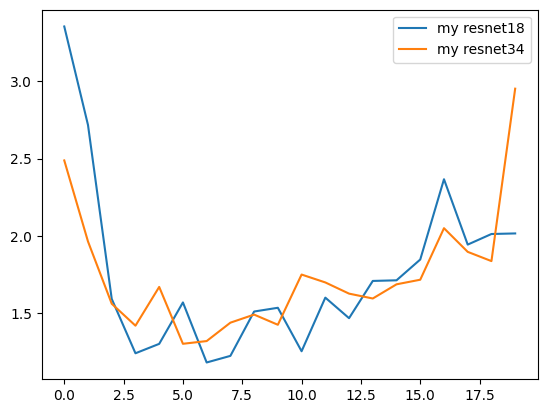

In [ ]:
sns.lineplot(vll_my18, label="my resnet18")
sns.lineplot(vll_my_34, label="my resnet34")
sns.lineplot(vll_torch_18, label="torch resnet18")
sns.lineplot(vll_torch_34, label="torch resnet34")

plt.xlabel("Epoch")
plt.ylabel("Cross-entropy validation loss")

<Axes: >

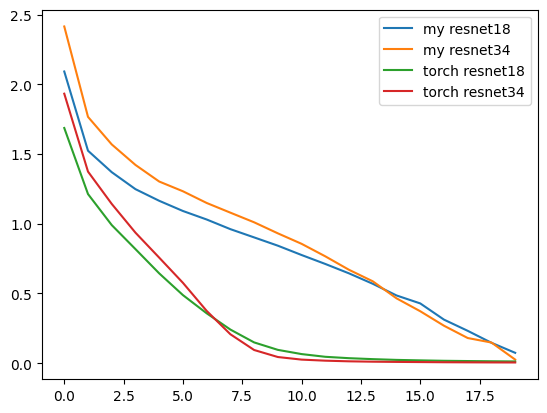

In [ ]:
sns.lineplot(tll_my_18, label="my resnet18")
sns.lineplot(tll_my_34, label="my resnet34")
sns.lineplot(tll_my_50, label="my resnet50")
sns.lineplot(tll_torch_18, label="torch resnet18")
sns.lineplot(tll_torch_34, label="torch resnet34")

plt.xlabel("Epoch")
plt.ylabel("Cross-entropy validation loss")

In [ ]:
best_my_resnet18.load_state_dict(torch.load("models/lab4-best-my_resnet18-parameters.pt"))
best_my_resnet18 = best_my_resnet18.to(device)
best_model.eval()

In [ ]:
torch_my_resnet18.load_state_dict(torch.load("models/lab4-best-torch_resnet18-parameters.pt"))
torch_my_resnet18 = best_my_resnet18.to(device)
torch_model.eval()